<a href="https://colab.research.google.com/github/burmina/Prog_eng_team_proj/blob/yuriy_taganov_branch/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import Xception

import kagglehub

# Download latest version
path = kagglehub.dataset_download("marquis03/plants-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/marquis03/plants-classification/versions/1


In [ ]:
def create_dataframe(folder_path):
    data = {'image_path': [], 'labels': []}

    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_folder_path):
            for image_file in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_file)

                labels = class_folder

                data['image_path'].append(image_path)
                data['labels'].append(labels)

    df = pd.DataFrame(data)
    return df



dataset_path = path

train_df = create_dataframe(os.path.join(dataset_path, 'train'))
test_df = create_dataframe(os.path.join(dataset_path, 'test'))
valid_df = create_dataframe(os.path.join(dataset_path, 'val'))


In [ ]:
all_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
all_df


,image_path,labels
0,/root/.cache/kagglehub/datasets/marquis03/plan...,guava
1,/root/.cache/kagglehub/datasets/marquis03/plan...,guava
2,/root/.cache/kagglehub/datasets/marquis03/plan...,guava
3,/root/.cache/kagglehub/datasets/marquis03/plan...,guava
4,/root/.cache/kagglehub/datasets/marquis03/plan...,guava
...,...,...
29995,/root/.cache/kagglehub/datasets/marquis03/plan...,mango
29996,/root/.cache/kagglehub/datasets/marquis03/plan...,mango
29997,/root/.cache/kagglehub/datasets/marquis03/plan...,mango
29998,/root/.cache/kagglehub/datasets/marquis03/plan...,mango


In [ ]:
ds_name = 'Plant Classification'


In [ ]:
def num_of_examples(all_df, name='df'):
    print(f"{name} dataset {all_df.shape[0]} has a number of images.")

num_of_examples(all_df, ds_name)

Plant Classification dataset 30000 has a number of images.


In [ ]:
def num_of_classes(all_df, name='df'):
    print(f"{name} in the dataset {len(all_df['labels'].unique())} there is a class.")

num_of_classes(all_df, ds_name)

Plant Classification in the dataset 30 there is a class.


In [ ]:
def classes_count(all_df, name='df'):

    print(f"{name} in the dataset:")
    print("="*70)
    print()
    for name in all_df['labels'].unique():
        num_class = len(all_df['labels'][all_df['labels'] == name])
        print(f"'{name}' class {num_class} has a custom image. ")
        print('-'*70)

classes_count(all_df, ds_name)

Plant Classification in the dataset:

'guava' class 1000 has a custom image. 
----------------------------------------------------------------------
'tobacco' class 1000 has a custom image. 
----------------------------------------------------------------------
'paddy' class 1000 has a custom image. 
----------------------------------------------------------------------
'coconut' class 1000 has a custom image. 
----------------------------------------------------------------------
'soybeans' class 1000 has a custom image. 
----------------------------------------------------------------------
'eggplant' class 1000 has a custom image. 
----------------------------------------------------------------------
'galangal' class 1000 has a custom image. 
----------------------------------------------------------------------
'pineapple' class 1000 has a custom image. 
----------------------------------------------------------------------
'bilimbi' class 1000 has a custom image. 
---------------

In [ ]:
def cat_summary_with_graph(dataframe, col_name):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#1a1a1a', '#ff69b4', '#ffd700', '#008000', '#4b0082',
              '#e6e6fa', '#ff4500', '#8b4513', '#00ced1', '#dda0dd',
              '#bdb76b', '#7fffd4', '#8a2be2', '#ff8c00', '#9932cc',
              '#ff1493', '#00fa9a', '#8b0000', '#008b8b', '#483d8b']

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage Chart'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

cat_summary_with_graph(all_df, 'labels')

In [ ]:
def check_null_values(all_df, name='df'):

    num_null_vals = sum(all_df.isnull().sum().values)

    # if not num_null_vals:
    #     print(there is no empty(null) value in the f"{name} dataset.")

    # else:
    #     print(f"The {name} dataset has {num_null_val} null values.")
    #     print('-'*70)
    #     print('Total null values in each column:\n')
    #     print(all_df.isnull().sum())


check_null_values(all_df, ds_name)

In [ ]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)

ts_gen = ImageDataGenerator(preprocessing_function=scalar)


train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'image_path',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'image_path',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'image_path',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 21000 validated image filenames belonging to 30 classes.
Found 3000 validated image filenames belonging to 30 classes.
Found 6000 validated image filenames belonging to 30 classes.


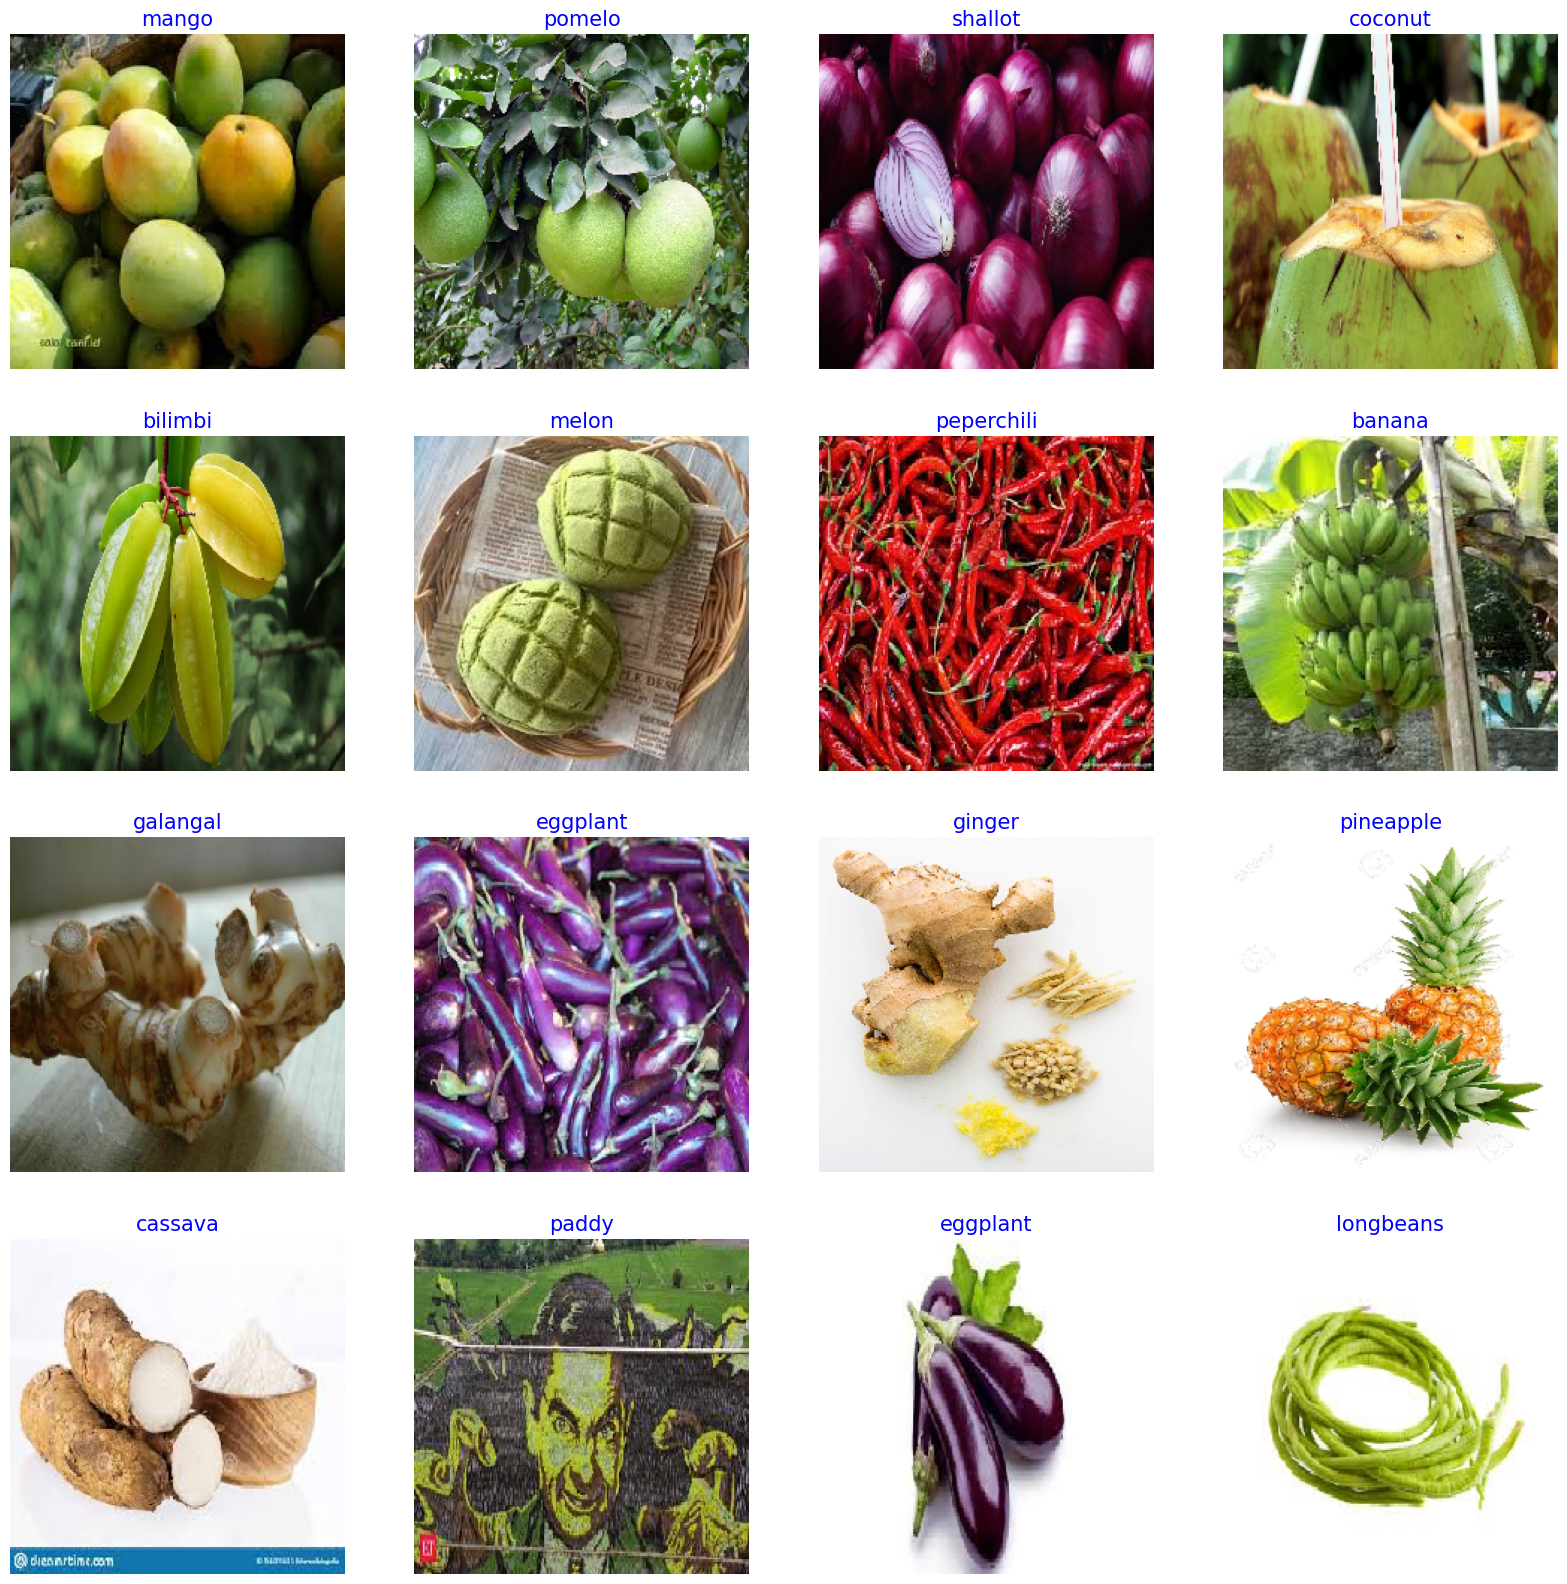

In [ ]:
g_dict = train_gen.class_indices

classes = list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)

    image = images[i] / 255

    plt.imshow(image)

    index = np.argmax(labels[i])

    class_name = classes[index]

    plt.title(class_name, color='blue', fontsize=15)

    plt.axis('off')

plt.show()

In [ ]:
img_size = (224, 224)

channels = 3

img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(128, kernel_regularizer=regularizers.l2(l2=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.3, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)          │ (None, 2560)                │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2560)                │          10,240 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,439,605 (245.82 MB)

 Trainable params: 336,798 (1.28 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

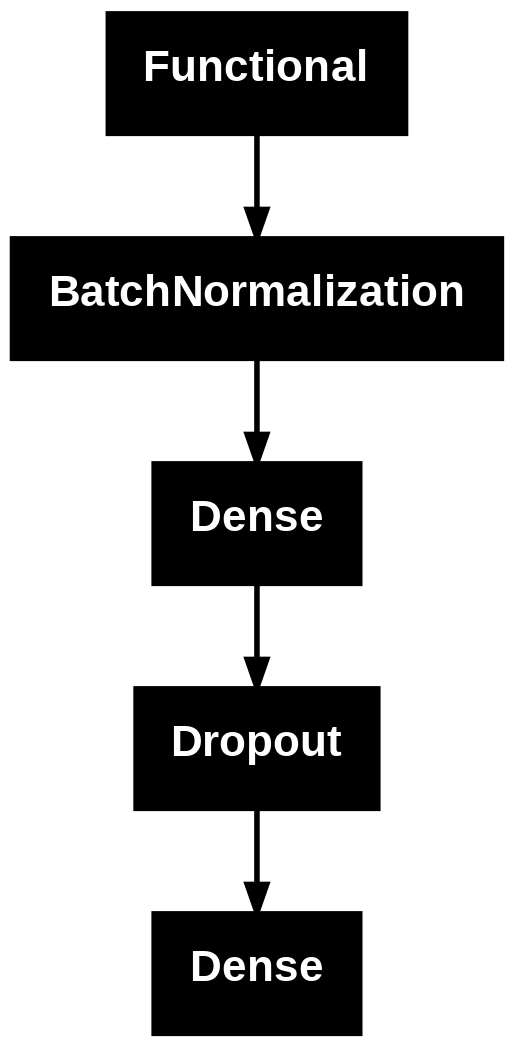

In [ ]:
from keras.utils import plot_model
plot_model(model)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
batch_size = 64
epochs = 30

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



367/525 ━━━━━━━━━━━━━━━━━━━━ 53:35 20s/step - accuracy: 0.1013 - loss: 10.0849

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'


plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Training Loss(Train Loss):", train_score[0])
print("Training Accuracy(Train Accuary):", train_score[1])
print('-'*20)
print("Validation Loss:", valid_score[0])
print("Validation Accuracy:", valid_score[1])
print('-'*20)
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (12, 12))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('Real Label')
plt.xlabel('Predictive Tag')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))


In [ ]:
model.save_weights('my_model_weights.h5')


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    predicted_class_label = class_labels[predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Vehicle: {predicted_class_label}")
    plt.show()

model.load_weights('/kaggle/working/my_model_weights.h5')

class_labels = list(train_gen.class_indices.keys())


image_path_to_test = '/kaggle/input/plants-classification/test/ginger/ginger800.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/plants-classification/test/watermelon/watermelon808.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/plants-classification/test/melon/melon802.jpg'
predict_and_display(image_path_to_test, model, class_labels)

In [ ]:
image_path_to_test = '/kaggle/input/plants-classification/test/bilimbi/bilimbi806.jpg'
predict_and_display(image_path_to_test, model, class_labels)